In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import glob
import tensorflow.keras.datasets.mnist as mnist
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
# 该网络模型过大，训练太慢，无法有效进行训练

os.listdir(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\apple2orange')
imgs_A = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\apple2orange/trainA/*.jpg')
imgs_A=imgs_A[:300]
imgs_B = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\apple2orange/trainB/*.jpg')
imgs_B=imgs_B[:300]
test_A = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\apple2orange/testA/*.jpg')
test_B = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\apple2orange/testB/*.jpg')
print(len(imgs_A),len(imgs_B),len(test_A),len(test_B))

300 300 266 248


In [3]:
def read_jpg(path):
    '''
    读取存放图片的路径，并将该路径转换为图片数据
    '''
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    return img

def normalize(input_image):
    '''
    对图片进行归一化到-1到1
    image为图片
    '''
    input_image=tf.cast(input_image,tf.float32)/127.5-1
    return input_image 

def load_image(image_path):
    '''
    将图片进行数字化，裁剪、归一化
    '''
    # 数字化图片
    image=read_jpg(image_path) # shape(w,h,c)
    
    # resize
    input_image=tf.image.resize(image,(128,128))  # (256,256,3)
    
    # 数据归一化
    input_image=normalize(input_image)
    return input_image

BUFFER_SIZE = 80

# 建立数据集
trainA_dataset=tf.data.Dataset.from_tensor_slices(imgs_A)
trainB_dataset=tf.data.Dataset.from_tensor_slices(imgs_B)
testA_dataset=tf.data.Dataset.from_tensor_slices(test_A)
testB_dataset=tf.data.Dataset.from_tensor_slices(test_B)

trainA_dataset=trainA_dataset.map(load_image,
                                  num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
trainB_dataset=trainB_dataset.map(load_image,
                                  num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
testA_dataset=testA_dataset.map(load_image,
                               num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
testB_dataset=testB_dataset.map(load_image,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

train_dataset=tf.data.Dataset.zip((trainA_dataset,trainB_dataset))
test_dataset=tf.data.Dataset.zip((testA_dataset,testB_dataset))

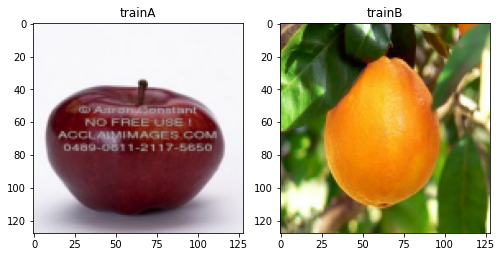

In [4]:
# 查看一个处理好的train和test图片
plt.figure(figsize=(7,5))
for img,mask in zip(trainA_dataset.take(1),trainB_dataset.take(1)):
    plt.subplot(1,2,1)
    plt.title('trainA')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.title('trainB')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.tight_layout()

In [5]:
import tensorflow_addons as tfa

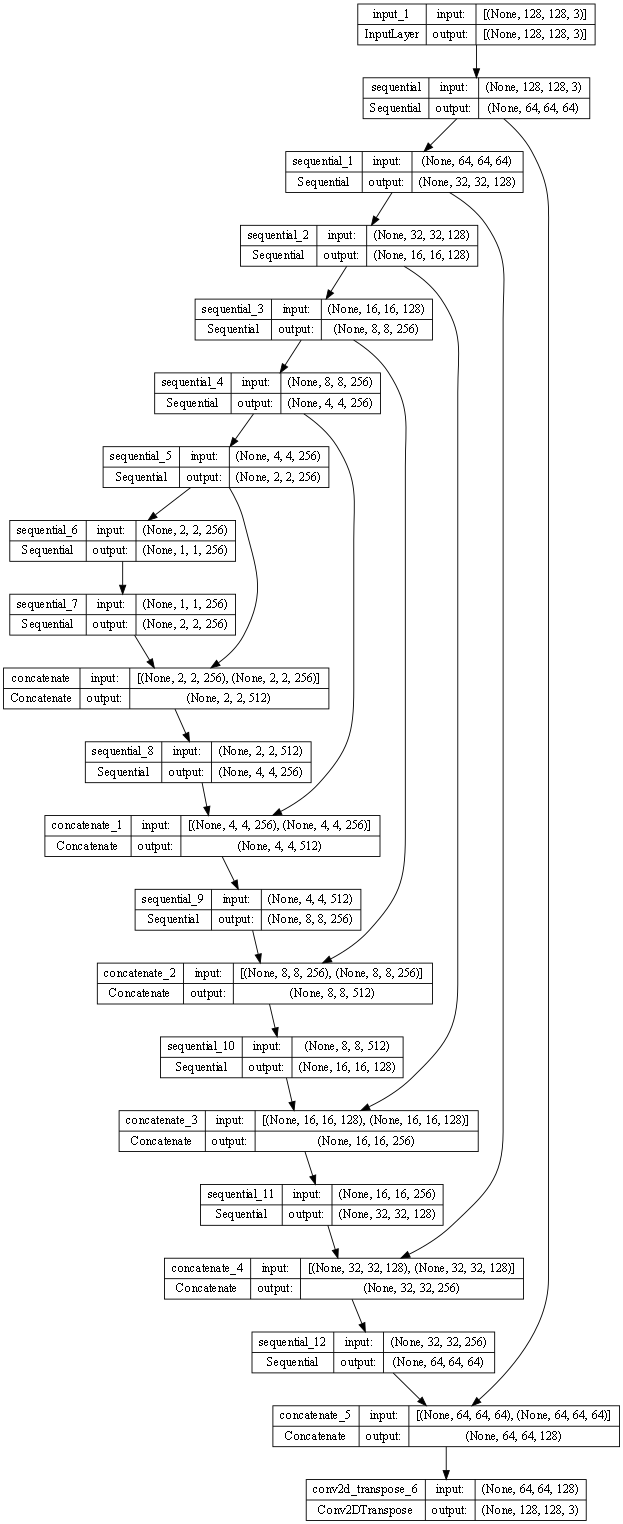

In [6]:
def downsample(filters,size,apply_batchnorm=True):
    '''
    filters: 输出通道数
    size: 卷积核尺寸
    '''
    result=tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',
                              use_bias=False))
    
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())
        
        result.add(tf.keras.layers.LeakyReLU())
    return result


def upsample(filters,size,apply_dropout=False):
    result=tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',
                              use_bias=False))
    result.add(tfa.layers.InstanceNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
        result.add(tf.keras.layers.ReLU())
    return result


def generator():
    inputs=tf.keras.layers.Input(shape=[128,128,3])
    OUTPUT_CHANNELS = 3
    
    down_stack=[
        downsample(64,4,apply_batchnorm=False),# （batchsize,64,64,512）
        downsample(128,4),# （batchsize,32,32,512）
        downsample(128,4),# （batchsize,16,16,512）
        
        downsample(256,4),# （batchsize,8,8,512）
        downsample(256,4),  # （batchsize,4,4,512）
        downsample(256,4), # （batchsize,2,2,512）
        downsample(256,4) # （batchsize,1,1,512）
    ]
    
    up_stack=[
            upsample(256,4,apply_dropout=True),# （batchsize,2,2,512）
            upsample(256,4,apply_dropout=True),# （batchsize,4,4,512）
            upsample(256,4),# （batchsize,8,8,512）
            
            upsample(128,4),# （batchsize,16,16,512）
            upsample(128,4),# （batchsize,32,32,512）
            upsample(64,4) # （batchsize,64,64,4）
    ]
    
    last=tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,2,
                                        strides=2,
                                        padding='same',
                                        activation='tanh') # （batchsize,128,128,3）
    x=inputs
    skips=[]
    
    # 依次进行下采样
    for down in down_stack:
        x=down(x)
        skips.append(x) # 将每次下采样的值记录
    
    skips=reversed(skips[:-1]) # 先取出前n-1个值，再将他们反序排列
    
    # 依次进行上采样，并进行残差连接
    
    for up,skip in zip(up_stack,skips):
        x=up(x)
        x=tf.keras.layers.Concatenate()([x,skip])
    
    x=last(x) # 最后再经过一层卷积
    
    return tf.keras.Model(inputs=inputs,outputs=x)


def discriminator():
#     inp=tf.keras.layers.Input(shape=[256,256,3],name='input_image')
    inp=tf.keras.layers.Input(shape=[128,128,3],name='input_image')

    
    down1=downsample(64,4,False)(inp)
    down2=downsample(128,4)(down1)
    down3=downsample(256,4)(down2)  # (bacth,32,32,256)
    
    zero_pad1=tf.keras.layers.ZeroPadding2D()(down3) # (bacth,34,34,256)
    conv=tf.keras.layers.Conv2D(256,4,strides=1,use_bias=False)(down3) # (batch,31,31,256)
    
    batchnorm1=tfa.layers.InstanceNormalization()(conv)
    
    leaky_relu=tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2=tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bacth,33,33,256)
    last=tf.keras.layers.Conv2D(1,4,strides=1)(zero_pad2) # (bacth,30,30,1)
    
    return tf.keras.Model(inputs=inp,outputs=last)

generator_A=generator()
generator_B=generator()
discriminator_A=discriminator()
discriminator_B=discriminator()
tf.keras.utils.plot_model(generator_A, show_shapes=True, dpi=64)

In [17]:
discriminator_B.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 sequential_29 (Sequential)  (None, 64, 64, 64)        3072      
                                                                 
 sequential_30 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_31 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 256)       1048576   
                                                                 
 instance_normalization_29 (  (None, 13, 13, 256)      512       
 InstanceNormalization)                                          
                                                           

In [8]:
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_gneerated_output):
    generated_loss=loss_object(tf.ones_like(disc_gneerated_output),disc_gneerated_output)

    return generated_loss

def discriminator_loss(disc_real_output,gen_output):
    real_Loss=loss_object(tf.ones_like(disc_real_output),
                         disc_real_output)
    gen_Loss=loss_object(tf.zeros_like(gen_output),
                     gen_output)
    return real_Loss+gen_Loss

def cycle_cycle_loss(real_image,cycled_image):
    LAMBDA = 7
    loss1=tf.reduce_mean(tf.abs(real_image-cycled_image))
    return loss1*LAMBDA
    

# 优化器
generator_A_opti=tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
generator_B_opti=tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_A_opti=tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_B_opti=tf.keras.optimizers.Adam(1e-4,beta_1=0.5)

In [9]:
tf.config.run_functions_eagerly(True)

@tf.function  # 函数修饰器,将用户定义的python风格的函数代码转化成高效的tensorflow计算图
                # 可以加速网络的推理速度,还能够有效降低占用显卡显存,使低显存的显卡也可以跑大网络
def train_step(image_A,image_B):
    
    with tf.GradientTape(persistent=True) as tape:
        fake_B=generator_A(image_A,training=True)    # 输入苹果去生成橘子，A为苹果，B为橘子
        cycled_A=generator_B(fake_B,training=True)    # 
        
        
        fake_A=generator_B(image_B,training=True)    # 输入
        cycled_B=generator_A(fake_A,training=True)    # 输入
        
        
        # 输出结果向量
        disc_real_A=discriminator_A(image_A,training=True) # 输入真实图像去判别
        disc_real_B=discriminator_B(image_B,training=True) # 输入生成图像去判别

        disc_fake_A=discriminator_A(fake_A,training=True) # 输入真实图像去判别
        disc_fake_B=discriminator_B(fake_B,training=True) # 输入生成图像去判别
        
        # 输出计算的loss 
        gen_A_loss=generator_loss(disc_fake_B)
        gen_B_loss=generator_loss(disc_fake_A)
        
        total_cycle_loss=(cycle_cycle_loss(image_A,cycled_A)
                          +cycle_cycle_loss(image_B,cycled_B))
        # 总生成器损失-对抗性损失、=循环损失
        total_gan_A_loss=gen_A_loss+total_cycle_loss
        total_gan_B_loss=gen_B_loss+total_cycle_loss
        
        disc_A_loss=discriminator_loss(disc_real_A,disc_fake_A)
        disc_B_loss=discriminator_loss(disc_real_B,disc_fake_B)
    
    # 计算生成器和判别器梯度
    gradient_A_gen=tape.gradient(total_gan_A_loss,generator_A.trainable_variables)
    gradient_B_gen=tape.gradient(total_gan_B_loss,generator_B.trainable_variables)
    gradient__A_disc=tape.gradient(disc_A_loss,discriminator_A.trainable_variables)
    gradient__B_disc=tape.gradient(disc_B_loss,discriminator_B.trainable_variables)
    
    # 梯度优化
    generator_A_opti.apply_gradients(zip(gradient_A_gen,generator_A.trainable_variables))
    generator_B_opti.apply_gradients(zip(gradient_B_gen,generator_B.trainable_variables))
    
    discriminator_A_opti.apply_gradients(zip(gradient__A_disc,discriminator_A.trainable_variables))
    discriminator_B_opti.apply_gradients(zip(gradient__B_disc,discriminator_B.trainable_variables))

In [10]:
def generator_plot_image(gen_model,test_input):  # 
    pred_images=gen_model(test_input,training=False) # 查看利用噪声数据生成出16的图像

    fig=plt.figure(figsize=(10,5))
    display_List=[test_input[0],pred_images[0]]
    title=['input_image','predicted image']
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_List[i]*0.5+0.5) # 画出利用噪声数据gen出的图像
        plt.axis('off')
    plt.show()

In [11]:
def train(dataset,epochs,test_dataset):
    for epoch in range(epochs):
#         c_num=0  # 记录训练样本的个数
        for img_a,img_b in dataset:
            train_step(img_a,img_b)
            #  # 记录训练样本的个数
#             c_num+=1
#             print(c_num,end='')
            
        print('.',end='')
        # 判断利用test数据进行GAN画图
        if epoch%5==0:
            # 画noise生成的图
            for test_a,test_b in test_dataset.take(1):
                generator_plot_image(generator_A,test_a)
        print('将开始第{}轮epoch'.format(epoch+1))
    
    # 将最后一次epoch的图画出
    generator_plot_image(generator_A,test_a)

.

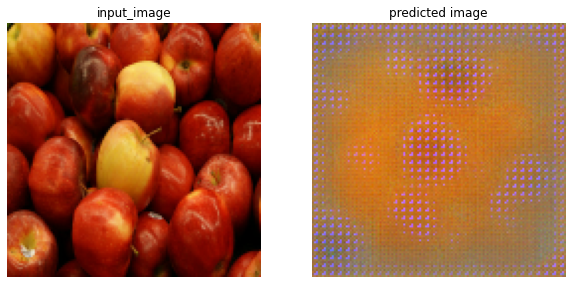

将开始第1轮epoch
.将开始第2轮epoch
.将开始第3轮epoch


KeyboardInterrupt: 

In [12]:
epochs=100
train(train_dataset,epochs,test_dataset)

In [14]:
generator_A.save('gen_model/cycle_Gen_A.h5')
generator_B.save('gen_model/cycle_Gen_B.h5')